# An Unequal-Variance Model of Positive Evidence Bias 

Subjective confidence ratings in perceptual 2 Alternative Forced Choice (2AFC) tasks have been shown to be disproportionally affected by evidence supporting the perceptual decision compared to contradicting evidence (e.g. Koizumi et al., 2015; Odegaard et al., 2018; Peters et al., 2017; Rausch et al., 2017; Samaha et al., 2016, 2017, 2019; Zylberberg et al., 2012). In a typical experiment, participatns are asked to decide whether the general direction of motion in a randomly moving dot array is left or right, and then rate their confidence in their decision. Increasing the total number of dots that are moving to the left and to the righ has no effect on accuracy, but enhances overall confidence. In a recent study, Samaha and Denison (2020) demonstrated that this Positive Evidence Bias (PEB) is not post-decisional. 

Here I show that PEB is expected when allowing for the signal channel to have more variance than the noise channel.

## Basic Model

A good-enough description of our moving-dot experiment is that on each trial the participant observes two quantities: the total motion energy (or the number of points moving) to the right ($E_r$), and the total motion energy to the left ($E_l$). Then, the participant uses the log likelihood ratio ($LLR = log(p(E_r,E_l|right))-log(p(E_r,E_l|left))$ to decide <span style="font-variant:small-caps;">left</span> or <span style="font-variant:small-caps;">right</span>. Confidence can be proportional to $|LLR|$. Motion energy for the true direction is sampled from a Gaussian with mean 1($E_t \sim \mathcal{N}(1,1)$), and motion energy for the opposite direction is sampled from a Gaussian with mean 0 ($E_o \sim \mathcal{N}(0,1)$). 

For the first model, the participant computed the LLR using the difference $E_r-E_l$ and using the fact that the difference between two normal distributions is itself a normal distribution , with its mean being the difference between the two means, and its variance being the sum of the two variances.

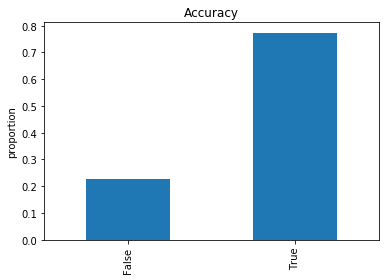

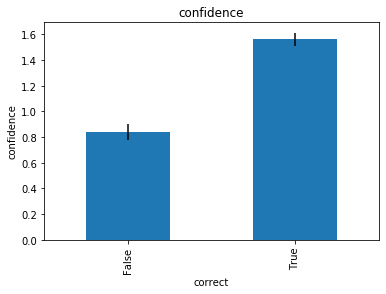

In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm
from scipy.stats import poisson
import statsmodels.formula.api as sm

np.random.seed(1)

class Model:
    def __init__(self, mu, sigma):
        
        self.df = pd.DataFrame()
        self.mu = mu
        self.sigma = sigma
    
    def runModel(self, num_trials):

        # first, decide which is the true direction in each trial (p=0.5)
        self.df['direction'] = ['r' if flip else 'l' for flip in np.random.binomial(1,0.5,num_trials)] 

        self.getMotionEnergy()
        
        self.extractLLR()

        self.makeDecision()

        self.rateConfidence()
        
        self.df['correct'] = self.df.apply(lambda row: row.direction==row.decision, axis=1)
        
        #energy in chosen direction
        self.df['E_c'] = self.df.apply(lambda row: row.E_r if row.decision=='r' else row.E_l, axis=1)
        
        #energy in unchosen direction
        self.df['E_u'] = self.df.apply(lambda row: row.E_l if row.decision=='r' else row.E_r, axis=1)
        
    def getMotionEnergy(self):
    # sample the motion energy for left and right as a function of the true direction
        self.df['E_r'] = self.df.apply(lambda row: np.random.normal(self.mu[1] if row.direction=='r' else self.mu[0],\
                               self.sigma[1]**2 if row.direction=='r' else self.sigma[0]**2), axis=1)

        self.df['E_l'] = self.df.apply(lambda row: np.random.normal(self.mu[1] if row.direction=='l' else self.mu[0],\
                               self.sigma[1]**2 if row.direction=='l' else self.sigma[0]**2), axis=1)
    
    def extractLLR(self):
        
        # extract the Log Likelihood Ratio (LLR) log(p(Er|r))-log(p(Er|l)) + log(p(El|r))-log(p(El|l))
        self.df['LLR'] = self.df.apply(lambda row: \
                            np.log(norm.pdf(row.E_r,self.mu[1],self.sigma[1]**2))- \
                            np.log(norm.pdf(row.E_r,self.mu[0],self.sigma[0]**2)) + \
                            np.log(norm.pdf(row.E_l,self.mu[0],self.sigma[0]**2))- \
                            np.log(norm.pdf(row.E_l,self.mu[1],self.sigma[1]**2)), axis=1)
    def makeDecision(self):
        
        # we assume that our participant just chooses the direction associated with higher likelihood
        self.df['decision'] =  self.df.apply(lambda row: 'r' if row.LLR>0 else 'l', axis=1)
        
    def rateConfidence(self):
        
        # and rates their confidence in proportion to the absolute LLR
        self.df['confidence'] = abs(self.df['LLR'])
    
    def plot(self):
        # plot accuracy
        self.df['correct'].value_counts(normalize=1,sort=0).plot(kind='bar',title='Accuracy')
        plt.ylabel('proportion')
        plt.show()

        # plot confidence as a function of accuracy
        self.df.groupby('correct').mean()['confidence'].plot(kind='bar',title='confidence', 
                                                             yerr=self.df.groupby('correct').sem()['confidence'])
        plt.ylabel('confidence')
        plt.show()
    
    def plotPEB(self):
        ax1 = sns.regplot(x="confidence", y='E_c',data=self.df)
        sns.regplot(x="confidence", y='E_u',data=self.df,ax=ax1,color='red')
        ax1.set(ylabel="motion energy")
        ax1.legend(labels=['chosen', 'unchosen'])
        
        #get coefficients
        self.ols = sm.ols(formula="confidence ~ E_c + E_u", data=self.df).fit()
        self.corr_chosen = self.df.confidence.corr(self.df.E_c)
        self.corr_unchosen = self.df.confidence.corr(self.df.E_u)
        
        print("Correlation of confidence with chosen : % .2f, unchosen : % .2f" %\
          (self.corr_chosen,self.corr_unchosen)) 

model01 = Model(mu=[0,1],sigma=[1,1])
model01.runModel(num_trials = 500)
model01.plot()

The next thing that we want to do is to plot is the motion energy in the chosen and unchosen directions as a function of decision confidence. We expect a positive correlation of confidence with the chosen direction and a negative correlation with the unchosen direction.

Correlation of confidence with chosen :  0.56, unchosen : -0.58


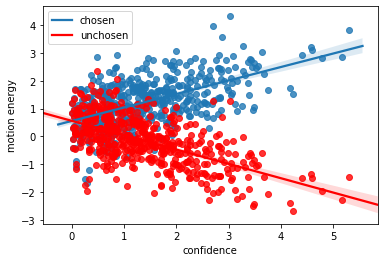

In [9]:
# plot confidence against motion energy in chosen and unchosen directions
model01.plotPEB()

This very simplistic model shows no PEB, as evident from the negative slope for motion energy in the unchosen direction as a function of confidence, and from the fact that the correlation coefficients for $E_c$ and $E_u$ are very similar (but in opposite directions).

## Unequal Variance Model

The next model will be identical to this first model, except that we are going to take one additional fact into account: the variance of signal is typically higher than the variance of noise. So if the dots were moving to the right, $E_r$ should be sampled from a distribution of higher variance compared to $E_l$. In the following simulation I've chosen the arbitrary values of $E_t \sim \mathcal{N}(1,1.2)$ and $E_o \sim \mathcal{N}(0,1)$. 

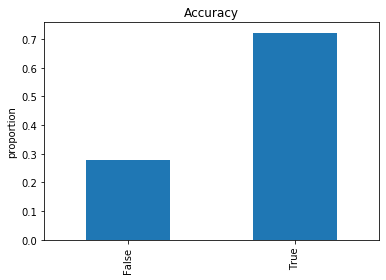

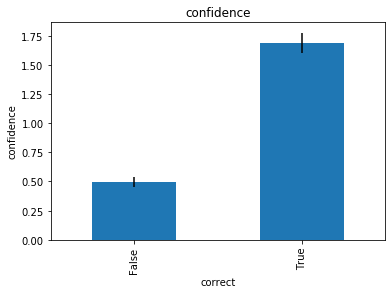

Correlation of confidence with chosen :  0.84, unchosen :  0.02


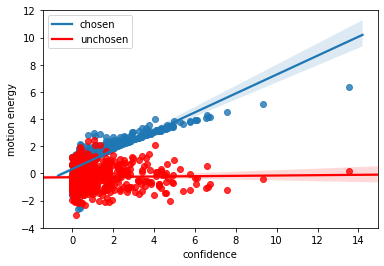

In [10]:
model02 = Model(mu=[0,1],sigma=[1,1.2]); # here sigma is different for the true and opposite directions
model02.runModel(num_trials = 500)
model02.plot()
model02.plotPEB() 

Making the variance of the motion energy in the true direction higher gives rise to PEB. Notice that all we changed was increasing the variance of the true direction or motion from 1 to 1.2! If this is a true PEB and not merely higher correlation with motion energy in the true direction, we should see it not only for correct responses, but also for incorrect responses (Kiani et al., 2014; Rausch & Zehetleitner, 2016):

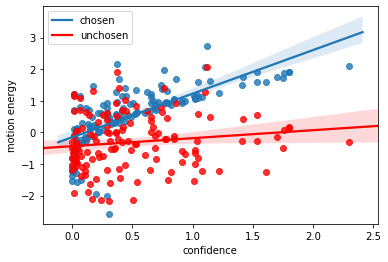

Correlation of confidence with chosen :  0.84, unchosen :  0.02


In [39]:
errors = model02.df[model02.df.correct==0]
ax1 = sns.regplot(x="confidence", y='E_c',data=errors)
sns.regplot(x="confidence", y='E_u',data=errors,ax=ax1,color='red')
ax1.set(ylabel="motion energy")
ax1.legend(labels=['chosen', 'unchosen'])
plt.show()

print("Correlation of confidence with chosen : % .2f, unchosen : % .2f" %\
      (model02.corr_chosen,model02.corr_unchosen)) 

To reiterate, a change to the variance of the motion energy in the true direction of motion (from 1 to 1.2) gave rise to an effect that can look metacognitive or higher-order, although in this simulation it is not. There are two main reasons for assuming higher variance in the true direction of motion (or true orientation of a visual grating). First, often this is how the experiment is designed in the first place. For example, in Zylberberg et al (2012) a small set of coherently moving dots was embedded in an array of randomly moving dots. Importantly, the number of coherently moving dots was itself randomly determined, sampled from a Gaussian distribution once in every four frames. This means that there were two sources of variability for the true direction of motion (variability in the randomly moving dots and variability in the number of coherently moving dots), but only one source of variability for the opposite direction. Secondly, the representation of signal is empirically more noisy than the representaion of noise, as evident from the better fit of unequal-variance SDT models to visual detection behavioural data.

Let's examine one more biologically-inspired variant of this model, using Poisson instead of normal distributions to represent the incoming perceptual evidence supporting right or left motion. This resembles neuronal firing rate, or the number of neurons from an orientation-selective population that exceeded a certain firing-rate threshold in response to a stimulus.

## Poisson Model

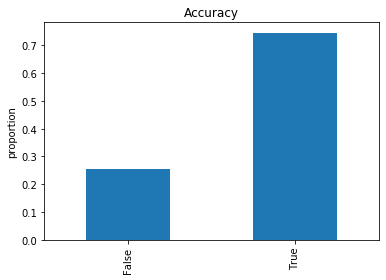

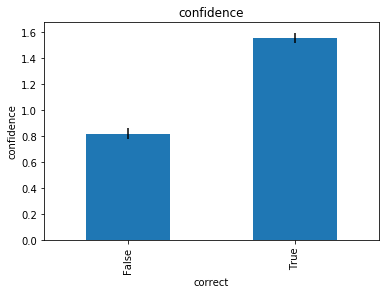

Correlation of confidence with chosen :  0.76, unchosen : -0.36


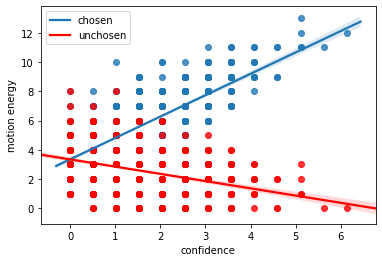

In [50]:
#inherit class Model and make a few changes
class PoissonModel(Model):
    
    # poisson distribution has only one parameter
    def __init__(self, lmbda):
        
        self.df = pd.DataFrame()
        self.lmbda = lmbda
        
    def getMotionEnergy(self):
    # sample the motion energy for left and right as a function of the true direction
        self.df['E_r'] = self.df.apply(lambda row: np.random.poisson(self.lmbda[1] if row.direction=='r' else self.lmbda[0]), \
                                       axis=1)

        self.df['E_l'] = self.df.apply(lambda row: np.random.poisson(self.lmbda[1] if row.direction=='l' else self.lmbda[0]), \
                                       axis=1)
    
    def extractLLR(self):
        
        # extract the Log Likelihood Ratio (LLR) log(p(Er|r))-log(p(Er|l)) + log(p(El|r))-log(p(El|l))
        self.df['LLR'] = self.df.apply(lambda row: \
                            np.log(poisson.pmf(row.E_r,self.lmbda[1]))- \
                            np.log(poisson.pmf(row.E_r,self.lmbda[0])) + \
                            np.log(poisson.pmf(row.E_l,self.lmbda[0]))- \
                            np.log(poisson.pmf(row.E_l,self.lmbda[1])), axis=1)

model03 = PoissonModel(lmbda=[3,5])
model03.runModel(num_trials = 1000)
model03.plot()   
model03.plotPEB() 

Again, the model is predicting a positive evidence bias, and the effect persists in error trials too:

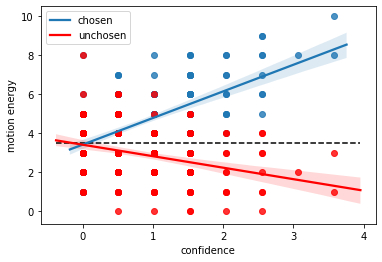

In [57]:
errors = model03.df[model03.df.correct==0]
ax1 = sns.regplot(x="confidence", y='E_c',data=errors)
sns.regplot(x="confidence", y='E_u',data=errors,ax=ax1,color='red')
ax1.set(ylabel="motion energy")
ax1.legend(labels=['chosen', 'unchosen'])
ax1.hlines(3.5,ax1.get_xlim()[0],ax1.get_xlim()[1], linestyles='dashed')
plt.show()
